In [1]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)
import moviepy.editor as mpy
from sklearn.preprocessing import StandardScaler

In [2]:
# https://www.youtube.com/watch?v=Bcuj2fTH4_4 (replay experience)
# https://www.youtube.com/watch?v=0bt0SjbS3xc&list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv&index=13 (Train process)
# https://www.youtube.com/watch?v=xVkPh9E9GfE&list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv&index=14 (target network)

In [3]:
import gym
from keras import models
from keras import layers
from keras.optimizers import Adam
from keras.regularizers import l2
from collections import deque
import random
import numpy as np
from time import time
from tensorboardX import SummaryWriter
from matplotlib import pyplot as plt


#############################
#if you want to use GPU to boost, use these code.  

# import tensorflow as tf
# import keras
# config = tf.ConfigProto( device_count = {'GPU': 2 , 'CPU': 1} ) 
# sess = tf.Session(config=config) 
# keras.backend.set_session(sess)

#############################


class DDQNAgent:
    def __init__(self,env, episodeNum=400, iterationNum=201):
        self.start_time = int(time())
        self.env=env
        self.seed = 1
        self.tao = 1.0
        self.gamma=0.99

        self.epsilon = 1.0
        self.epsilon_decay = 0.01

        self.epsilon_min=0.001


        self.learingRate=0.001

        self.replayBuffer=deque(maxlen=20000)
        self.trainNetwork=self.createNetwork()

        self.episodeNum=episodeNum

        self.iterationNum=iterationNum #max is 200

        self.numPickFromBuffer=32

        self.targetNetwork=self.createNetwork()

        self.targetNetwork.set_weights(self.trainNetwork.get_weights())
        
        self.best_reward = -np.infty
        
        self.writer = SummaryWriter(f'logs/deep/{self.start_time}_{self.gamma}_{self.learingRate}')
        
        state_space_samples = np.array(
            [self.env.observation_space.sample() for x in range(10000)])
        self.scaler = StandardScaler()
        self.scaler.fit(state_space_samples)
        
    def get_Q_table(self, res = 50):
        plt.ioff()
        x = np.linspace(self.env.observation_space.low[0], self.env.observation_space.high[0], res)
        y = np.linspace(self.env.observation_space.low[1], self.env.observation_space.high[1], res)
        xx, yy = np.meshgrid(x, y)
        dataset = np.c_[xx.ravel(), yy.ravel()]
        dataset = self.scaler.transform(dataset)
        Q_table = self.targetNetwork.predict(dataset, verbose=0).reshape(res, res, self.env.action_space.n)
        f = plt.figure()
        cs = plt.contourf(xx, yy, np.argmax(Q_table, axis=2)/2, levels=[0, 0.33, 0.66, 1], cmap='gray')  #, vmin=0, vmax=2
        plt.xlabel('posición')
        plt.ylabel('velocidad')
        cbar = plt.colorbar()
        cbar.set_ticks(np.array([0, 1, 2])/2)
        cbar.set_ticklabels(['push left', 'no push', 'push right'])
        plt.close(f)
        plt.ion()
        return f

    def eval_model(self, eps, epsilon, video_to_board=False):
        i = 0
        rewardSum = 0
        done = False
        frames = []
        self.env.seed(self.seed)
        state = self.env.reset()
        while not done:
            state = self.scaler.transform(np.array([state]))
            action = np.argmax(self.targetNetwork.predict(state))
            new_state, reward, done, _ = self.env.step(action)
            if video_to_board:
                frames.append(self.env.render(mode = 'rgb_array'))
            state = new_state
            i+=1
            rewardSum += reward
        if video_to_board:
            frames = np.array(frames)
            video = np.array(frames).reshape((1, )+frames.shape)
            self.writer.add_video(f'{self.start_time}/{eps}_{rewardSum}_{epsilon}/render', np.rollaxis(video, 4, 2), fps=20)
            self.writer.flush()
        return rewardSum

    def createNetwork(self):
        model = models.Sequential()
        state_shape = self.env.observation_space.shape
        lmda = 0 #1e-5
        model.add(layers.Dense(24, input_shape=state_shape, kernel_regularizer=l2(lmda)))
#         model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Dense(48, kernel_regularizer=l2(lmda)))
#         model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Dense(self.env.action_space.n,activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learingRate))
        return model

    def getBestAction(self,state):

        self.epsilon = max(self.epsilon_min, self.epsilon)

        if np.random.rand(1) < self.epsilon:
            action = np.random.randint(0, 3)
        else:
            action=np.argmax(self.trainNetwork.predict(state)[0])

        return action

  
    def trainFromBuffer(self):
        if len(self.replayBuffer) < self.numPickFromBuffer:
            return

        samples = random.sample(self.replayBuffer,self.numPickFromBuffer)

        states = []
        newStates=[]
        for sample in samples:
            state, action, reward, new_state, done = sample
            states.append(state)
            newStates.append(new_state)

        newArray = np.array(states)
        states = newArray.reshape(self.numPickFromBuffer, self.env.observation_space.shape[0])

        newArray2 = np.array(newStates)
        newStates = newArray2.reshape(self.numPickFromBuffer, self.env.observation_space.shape[0])

        targets = self.trainNetwork.predict(states)
        new_state_targets=self.targetNetwork.predict(newStates)

        i=0
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = targets[i]
            if done:
                target[action] = reward
            else:
                Q_future = max(new_state_targets[i])
                target[action] = reward + Q_future * self.gamma
            i+=1

        self.trainNetwork.fit(states, targets, epochs=1, verbose=0)


    def orginalTry(self,currentState,eps):
        rewardSum = 0
        max_position=-99
        frames = []
        currentState = self.scaler.transform(currentState)
        for i in range(self.iterationNum):
            bestAction = self.getBestAction(currentState)

            new_state, reward, done, _ = self.env.step(bestAction)
    
            frames.append(self.env.render(mode = 'rgb_array'))

            new_state = new_state.reshape(1, self.env.observation_space.shape[0])
            
            # # Keep track of max position
            if new_state[0][0] > max_position:
                max_position = new_state[0][0]
                
            new_state = self.scaler.transform(new_state)
            


            # # Adjust reward for task completion
#             if new_state[0][0] >= 0.5:
#                 reward += 10

            self.replayBuffer.append([currentState, bestAction, reward, new_state, done])

            #Or you can use self.trainFromBuffer_Boost(), it is a matrix wise version for boosting 
            self.trainFromBuffer()

            rewardSum += reward

            currentState = new_state

            if done:
                break

#         if i >= 199:
#             print("Failed to finish task in epsoide {}".format(eps))
#         else:
#             print("Success in epsoide {}, used {} iterations!".format(eps, i))
#             self.trainNetwork.save('./trainNetworkInEPS{}.h5'.format(eps))

        #Sync
        self.targetNetwork.set_weights(self.tao*np.array(self.trainNetwork.get_weights()) + (1-self.tao)*np.array(self.targetNetwork.get_weights()))
        
        epsilon = max(self.epsilon_min, self.epsilon)
        
        eval_reward_sum = self.eval_model(eps, epsilon)
        
        self.writer.add_scalar('data/epsilon', epsilon, eps)
        self.writer.add_scalar('data/rewardSum', rewardSum, eps)
        self.writer.add_scalar('data/max_position', max_position, eps)
        self.writer.add_scalar('data/ep_len', i, eps)
        self.writer.add_scalar('data/rewardSum_eval', eval_reward_sum, eps)
        
        self.epsilon -= self.epsilon_decay
        
        
        
        if self.best_reward <= eval_reward_sum:
            frames = np.array(frames)
            video = frames.reshape((1, )+frames.shape)
#             self.writer.add_video(f'{self.start_time}/{eps}_{rewardSum}_{epsilon}/render', np.rollaxis(video, 4, 2), fps=20)
            if self.env.observation_space.shape[0] == 2:
                self.writer.add_figure(f'{self.start_time}/{eps}_{rewardSum}_{epsilon}/qtable', self.get_Q_table())
            self.eval_model(eps, epsilon, video_to_board=True)
            self.writer.flush()
#             self.save_video(f'{self.start_time}/{eps}_{rewardSum}_{i}')
            self.best_reward=eval_reward_sum
            # Hack para que no muestra tantas imagenes cuando empieza
            if eval_reward_sum <= -200.0:
                self.best_reward = -199.0

    def start(self):
        for eps in range(self.episodeNum):
            self.env.seed(self.seed)
            currentState=self.env.reset().reshape(1, self.env.observation_space.shape[0])
            self.orginalTry(currentState, eps)

Using TensorFlow backend.


In [4]:
dqn=DDQNAgent(env=gym.make('MountainCar-v0'), episodeNum=1000)
dqn.start()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


t:   7%|▋         | 14/201 [00:00<00:01, 130.92it/s, now=None]

MoviePy - Building file /tmp/tmp9jgem0wg.gif with imageio.


t:   8%|▊         | 13/155 [00:00<00:01, 129.53it/s, now=None]

MoviePy - Building file /tmp/tmptmo0ksg1.gif with imageio.


t:   9%|▉         | 14/155 [00:00<00:01, 131.23it/s, now=None]

MoviePy - Building file /tmp/tmp1bril5yw.gif with imageio.


t:   9%|▉         | 14/154 [00:00<00:01, 132.65it/s, now=None]

MoviePy - Building file /tmp/tmp55fl0cwg.gif with imageio.


t:   9%|▉         | 14/152 [00:00<00:01, 132.26it/s, now=None]

MoviePy - Building file /tmp/tmpxekv82i5.gif with imageio.


t:   9%|▉         | 14/149 [00:00<00:01, 131.83it/s, now=None]

MoviePy - Building file /tmp/tmpp8lasrp_.gif with imageio.


t:   9%|▉         | 13/142 [00:00<00:01, 128.50it/s, now=None]

MoviePy - Building file /tmp/tmp7qf11vzz.gif with imageio.


t:  11%|█         | 14/126 [00:00<00:00, 132.39it/s, now=None]

MoviePy - Building file /tmp/tmp7gatc6t3.gif with imageio.


t:  11%|█         | 14/126 [00:00<00:00, 131.82it/s, now=None]

MoviePy - Building file /tmp/tmpny6t38h2.gif with imageio.


t:  12%|█▏        | 14/121 [00:00<00:00, 134.84it/s, now=None]

MoviePy - Building file /tmp/tmpb1p8n2ev.gif with imageio.


t:  12%|█▏        | 14/114 [00:00<00:00, 133.70it/s, now=None]

MoviePy - Building file /tmp/tmpc8g258zl.gif with imageio.


t:  15%|█▌        | 14/92 [00:00<00:00, 130.24it/s, now=None]

MoviePy - Building file /tmp/tmp5y5z6xrk.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 134.27it/s, now=None]

MoviePy - Building file /tmp/tmp1a2xybo8.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 134.34it/s, now=None]

MoviePy - Building file /tmp/tmpq44yurto.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 130.08it/s, now=None]

MoviePy - Building file /tmp/tmp964vxt7s.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.34it/s, now=None]

MoviePy - Building file /tmp/tmpq88zzk9l.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 131.69it/s, now=None]

MoviePy - Building file /tmp/tmpz5l77red.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.56it/s, now=None]

MoviePy - Building file /tmp/tmp48skt6a8.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 129.77it/s, now=None]

MoviePy - Building file /tmp/tmpivjm8vwm.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.51it/s, now=None]

MoviePy - Building file /tmp/tmpv0njbwzp.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.46it/s, now=None]

MoviePy - Building file /tmp/tmpohby58s3.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 128.09it/s, now=None]

MoviePy - Building file /tmp/tmpph2b7_71.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 130.74it/s, now=None]

MoviePy - Building file /tmp/tmpu2xuejod.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 134.24it/s, now=None]

MoviePy - Building file /tmp/tmpscxbklno.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 134.11it/s, now=None]

MoviePy - Building file /tmp/tmpuhje_riw.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.54it/s, now=None]

MoviePy - Building file /tmp/tmptugfiqg_.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 131.89it/s, now=None]

MoviePy - Building file /tmp/tmpkkn1otzk.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.26it/s, now=None]

MoviePy - Building file /tmp/tmp4faftq1w.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 133.67it/s, now=None]

MoviePy - Building file /tmp/tmpn5rxtibo.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 134.69it/s, now=None]

MoviePy - Building file /tmp/tmpuweoj0sy.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.45it/s, now=None]

MoviePy - Building file /tmp/tmp3e3v1atd.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 129.63it/s, now=None]

MoviePy - Building file /tmp/tmp7g1frxll.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 131.26it/s, now=None]

MoviePy - Building file /tmp/tmperxc7ltq.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 134.72it/s, now=None]

MoviePy - Building file /tmp/tmpjhm9leix.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 131.42it/s, now=None]

MoviePy - Building file /tmp/tmpwnhe8pgx.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.36it/s, now=None]

MoviePy - Building file /tmp/tmpxgf45tu1.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 134.19it/s, now=None]

MoviePy - Building file /tmp/tmpeq9p932e.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.08it/s, now=None]

MoviePy - Building file /tmp/tmpnfi4rl3i.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 135.17it/s, now=None]

MoviePy - Building file /tmp/tmpvoxn3bb8.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 134.77it/s, now=None]

MoviePy - Building file /tmp/tmpg9pzqg4p.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 130.66it/s, now=None]

MoviePy - Building file /tmp/tmp07627lre.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 133.83it/s, now=None]

MoviePy - Building file /tmp/tmpbpa0oebk.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 130.11it/s, now=None]

MoviePy - Building file /tmp/tmpy9rwyck_.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.17it/s, now=None]

MoviePy - Building file /tmp/tmp711_72oi.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.85it/s, now=None]

MoviePy - Building file /tmp/tmppf2o49gw.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 131.38it/s, now=None]

MoviePy - Building file /tmp/tmpsqzr50cp.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 134.38it/s, now=None]

MoviePy - Building file /tmp/tmp3hqcqe4g.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 134.66it/s, now=None]

MoviePy - Building file /tmp/tmpl6tsy2im.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 134.03it/s, now=None]

MoviePy - Building file /tmp/tmpeiuj96tw.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 133.75it/s, now=None]

MoviePy - Building file /tmp/tmp928u0suf.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 133.87it/s, now=None]

MoviePy - Building file /tmp/tmpcdvj5dne.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 130.32it/s, now=None]

MoviePy - Building file /tmp/tmpekuc565q.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.41it/s, now=None]

MoviePy - Building file /tmp/tmpc5ki2wgu.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 128.82it/s, now=None]

MoviePy - Building file /tmp/tmp9h0smyl5.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 125.52it/s, now=None]

MoviePy - Building file /tmp/tmpa4bwnaqy.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.55it/s, now=None]

MoviePy - Building file /tmp/tmp9kddvonj.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.07it/s, now=None]

MoviePy - Building file /tmp/tmpo7fq_zq1.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.97it/s, now=None]

MoviePy - Building file /tmp/tmp9r010pnz.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.74it/s, now=None]

MoviePy - Building file /tmp/tmp53xvm4dj.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 128.17it/s, now=None]

MoviePy - Building file /tmp/tmpbnut9axk.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 128.53it/s, now=None]

MoviePy - Building file /tmp/tmprxnz72r0.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 124.93it/s, now=None]

MoviePy - Building file /tmp/tmpyk50macj.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 129.33it/s, now=None]

MoviePy - Building file /tmp/tmp0nud0g3k.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 126.83it/s, now=None]

MoviePy - Building file /tmp/tmpmuvzw2np.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.02it/s, now=None]

MoviePy - Building file /tmp/tmpbzrckccn.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 125.42it/s, now=None]

MoviePy - Building file /tmp/tmpaaar5f0x.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 128.66it/s, now=None]

MoviePy - Building file /tmp/tmpoh2m8u57.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.75it/s, now=None]

MoviePy - Building file /tmp/tmpe2mnqjo_.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 125.21it/s, now=None]

MoviePy - Building file /tmp/tmp26ewxb81.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 126.98it/s, now=None]

MoviePy - Building file /tmp/tmpa47fgba_.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.94it/s, now=None]

MoviePy - Building file /tmp/tmp48snqtiv.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 128.13it/s, now=None]

MoviePy - Building file /tmp/tmpdfn828qk.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 126.84it/s, now=None]

MoviePy - Building file /tmp/tmp20xy82j_.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 128.59it/s, now=None]

MoviePy - Building file /tmp/tmp3ddb_eu0.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 125.20it/s, now=None]

MoviePy - Building file /tmp/tmpzpc3kqz8.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 126.63it/s, now=None]

MoviePy - Building file /tmp/tmpu1hfrrnx.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 128.81it/s, now=None]

MoviePy - Building file /tmp/tmpy1e7zgct.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.26it/s, now=None]

MoviePy - Building file /tmp/tmpyb3wil7u.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 128.83it/s, now=None]

MoviePy - Building file /tmp/tmpctkyf_w0.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 125.08it/s, now=None]

MoviePy - Building file /tmp/tmp2yt88z8o.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 129.59it/s, now=None]

MoviePy - Building file /tmp/tmphvapjn4r.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 126.80it/s, now=None]

MoviePy - Building file /tmp/tmpvp73ya5y.gif with imageio.


t:  14%|█▎        | 12/88 [00:00<00:00, 116.59it/s, now=None]

MoviePy - Building file /tmp/tmpc54onwuh.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 126.84it/s, now=None]

MoviePy - Building file /tmp/tmpzbapijg7.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.00it/s, now=None]

MoviePy - Building file /tmp/tmp9k5kkp4o.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 129.90it/s, now=None]

MoviePy - Building file /tmp/tmp7gljmmjn.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 126.81it/s, now=None]

MoviePy - Building file /tmp/tmpr5ywj4bn.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.89it/s, now=None]

MoviePy - Building file /tmp/tmpugkwmbp_.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.03it/s, now=None]

MoviePy - Building file /tmp/tmpm8ehz1ca.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 128.04it/s, now=None]

MoviePy - Building file /tmp/tmpdu4ijw3f.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 122.79it/s, now=None]

MoviePy - Building file /tmp/tmpakyoj5tg.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.94it/s, now=None]

MoviePy - Building file /tmp/tmpvfvoaqc9.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 122.77it/s, now=None]

MoviePy - Building file /tmp/tmp14um2u_r.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.05it/s, now=None]

MoviePy - Building file /tmp/tmpnbcgjne9.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.26it/s, now=None]

MoviePy - Building file /tmp/tmpnife_ycg.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 126.85it/s, now=None]

MoviePy - Building file /tmp/tmp8zmfdzol.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 125.42it/s, now=None]

MoviePy - Building file /tmp/tmp732km4ci.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 125.90it/s, now=None]

MoviePy - Building file /tmp/tmpvdulz21y.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.87it/s, now=None]

MoviePy - Building file /tmp/tmpebbw2d22.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 125.96it/s, now=None]

MoviePy - Building file /tmp/tmp_6jnbj1j.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 126.60it/s, now=None]

MoviePy - Building file /tmp/tmpoudukcvr.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.74it/s, now=None]

MoviePy - Building file /tmp/tmpx0ms5v2z.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 126.82it/s, now=None]

MoviePy - Building file /tmp/tmp4mhdqjod.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.42it/s, now=None]

MoviePy - Building file /tmp/tmp5iolsdy5.gif with imageio.


t:  15%|█▍        | 13/88 [00:00<00:00, 127.77it/s, now=None]

MoviePy - Building file /tmp/tmpuy1gxz_0.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 130.72it/s, now=None]

MoviePy - Building file /tmp/tmpm797imwo.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.17it/s, now=None]

MoviePy - Building file /tmp/tmpwp284n8i.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 134.46it/s, now=None]

MoviePy - Building file /tmp/tmp4oqaknlq.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 134.32it/s, now=None]

MoviePy - Building file /tmp/tmphbhw8x3d.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 133.19it/s, now=None]

MoviePy - Building file /tmp/tmpkbzjs6d8.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 133.72it/s, now=None]

MoviePy - Building file /tmp/tmpu2eaj3de.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.61it/s, now=None]

MoviePy - Building file /tmp/tmpb39gxris.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 133.49it/s, now=None]

MoviePy - Building file /tmp/tmpaqfykbww.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 134.85it/s, now=None]

MoviePy - Building file /tmp/tmplh6weyg8.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 133.25it/s, now=None]

MoviePy - Building file /tmp/tmpkrs8s1u4.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.22it/s, now=None]

MoviePy - Building file /tmp/tmp94ikdc35.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.43it/s, now=None]

MoviePy - Building file /tmp/tmp5mc9oqqn.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 130.83it/s, now=None]

MoviePy - Building file /tmp/tmpqb1100ze.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 131.81it/s, now=None]

MoviePy - Building file /tmp/tmp_8b5sk4z.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 130.18it/s, now=None]

MoviePy - Building file /tmp/tmpx78kbx0q.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.71it/s, now=None]

MoviePy - Building file /tmp/tmp0_zenqd0.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 133.81it/s, now=None]

MoviePy - Building file /tmp/tmpxo1xkx8s.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 134.77it/s, now=None]

MoviePy - Building file /tmp/tmpyjciqpfk.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.36it/s, now=None]

MoviePy - Building file /tmp/tmp6wg14k6n.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 131.01it/s, now=None]

MoviePy - Building file /tmp/tmpf3p53h1m.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 129.24it/s, now=None]

MoviePy - Building file /tmp/tmpeuvcr5v7.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 131.18it/s, now=None]

MoviePy - Building file /tmp/tmpewwjyfvs.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 131.37it/s, now=None]

MoviePy - Building file /tmp/tmpbm28714t.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 131.10it/s, now=None]

MoviePy - Building file /tmp/tmpglupfngi.gif with imageio.


t:  16%|█▌        | 14/88 [00:00<00:00, 132.17it/s, now=None]

MoviePy - Building file /tmp/tmpz4r4u3g_.gif with imageio.


In [9]:
dqn=DDQNAgent(env=gym.make('LunarLander-v2'), episodeNum=1000, iterationNum=500)
dqn.start()

Instructions for updating:
Use tf.cast instead.


t:  28%|██▊       | 14/50 [00:00<00:00, 131.07it/s, now=None]

MoviePy - Building file /tmp/tmpyvt4ssen.gif with imageio.


t:   7%|▋         | 14/189 [00:00<00:01, 131.51it/s, now=None]

MoviePy - Building file /tmp/tmp_anwy4zt.gif with imageio.


t:   9%|▉         | 14/151 [00:00<00:01, 129.82it/s, now=None]

MoviePy - Building file /tmp/tmpplec790u.gif with imageio.


t:   9%|▉         | 14/159 [00:00<00:01, 134.08it/s, now=None]

MoviePy - Building file /tmp/tmpb98u_t1n.gif with imageio.


t:   8%|▊         | 13/161 [00:00<00:01, 128.98it/s, now=None]

MoviePy - Building file /tmp/tmp93lk_3rx.gif with imageio.


t:   7%|▋         | 13/181 [00:00<00:01, 121.57it/s, now=None]

MoviePy - Building file /tmp/tmpb6dtwiow.gif with imageio.


t:   7%|▋         | 13/193 [00:00<00:01, 129.74it/s, now=None]

MoviePy - Building file /tmp/tmp1xw645vk.gif with imageio.


t:   0%|          | 0/1000 [00:00<?, ?it/s, now=None]

MoviePy - Building file /tmp/tmpm8pdt63e.gif with imageio.


t:   1%|▏         | 13/1000 [00:00<00:07, 128.30it/s, now=None]

MoviePy - Building file /tmp/tmptt4cg54b.gif with imageio.


t:   1%|▏         | 13/947 [00:00<00:07, 128.91it/s, now=None]

MoviePy - Building file /tmp/tmp_0mjoru5.gif with imageio.


t:   2%|▏         | 14/757 [00:00<00:05, 131.98it/s, now=None]

MoviePy - Building file /tmp/tmpiq_06zre.gif with imageio.


t:   2%|▏         | 14/624 [00:00<00:04, 131.98it/s, now=None]

MoviePy - Building file /tmp/tmpdpbdjr_0.gif with imageio.


t:   2%|▏         | 14/659 [00:00<00:04, 131.39it/s, now=None]

MoviePy - Building file /tmp/tmpam8iuen3.gif with imageio.


t:   2%|▏         | 14/583 [00:00<00:04, 129.69it/s, now=None]

MoviePy - Building file /tmp/tmpytnau6ef.gif with imageio.


t:   4%|▍         | 14/325 [00:00<00:02, 131.22it/s, now=None]

MoviePy - Building file /tmp/tmpnrq6kbff.gif with imageio.


KeyboardInterrupt: 

In [71]:
def save_video(self, name):
    i = 0
    ep_return = 0
    done = False
    frames = []
    self.env.seed(self.seed)
    state = self.env.reset()
    while not done:
        action = np.argmax(self.targetNetwork.predict(np.array([state])))
        new_state, reward, done, _ = self.env.step(action)
        frames.append(self.env.render(mode = 'rgb_array'))
        state = new_state
        i+=1
        ep_return += reward
    frames = np.array(frames)
    video = np.array(frames).reshape((1, )+frames.shape)
    return video

In [73]:
video = save_video(dqn, 'test_2')

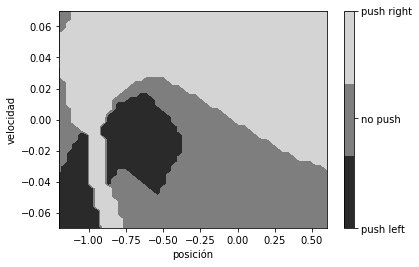

In [5]:
dqn.get_Q_table()

In [5]:
dqn.tao*dqn.trainNetwork.get_weights() + (1-dqn.tao)*dqn.targetNetwork.get_weights()

TypeError: can't multiply sequence by non-int of type 'float'

In [15]:
dqn.targetNetwork.set_weights(dqn.tao*np.array(dqn.trainNetwork.get_weights()) + (1-dqn.tao)*np.array(dqn.targetNetwork.get_weights()))